# Data Dive: Exploring Stock Returns

The today's exercise takes a look at stock data from [Alpha Vantage](https://www.alphavantage.co/documentation/). Stock returns can translate to enormous swings of wealth, and thus have long been the subject of statistical analysis. Today we'll take a look at just a handful of properties of stock returns. The bulk of our exercise will look at data for six stocks: AT&T (`T`), Apple (`AAPL`), Facebook (`FB`), General Electric (`GE`), IBM (`IBM`), and Microsoft (`MSFT`) and a fund that tracks the broader market: the [Vanguard S&P 500 ETF]() (`VOO`).  

![TP](https://media.giphy.com/media/NyCWiCGZpoLLO/source.gif)


#### Note: You'll Need an API Key for this exercise, and there are limits.
 * You can sign up for an API key [here](https://www.alphavantage.co/support/#api-key). 
 * The service is limited to 5 calls per minute, which is enough for us to do some light analysis, if we think carefully about how we use it. 

In [ ]:
import requests
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

#### Read in list of stocks and stock tickers

In order to be able to easily look up stock tickers, we can load a dictionary of all of the members of the S&P 500, a set of the largest 500 publicly traded stocks in the U.S.

In [ ]:
tickers = pd.read_csv(
    'https://datahub.io/core/s-and-p-500-companies/r/constituents.csv', 
    index_col=1
).to_dict()['Symbol']

companies = dict([(value, key) for key, value in tickers.items()]) 

In [ ]:
tickers['AT&T Inc.']


### Build a function to retrieve stock prices for a given portfolio. 

We'll tap the Alpha Vantage through a custom function we build on our own. The customization in the function here makes the rest of the exercise easy. 

In [ ]:
def get_stock_prices(
    portfolio=['T', 'FB', 'IBM', 'GE', 'AAPL', 'MSFT', 'VOO'],
    start_year=2013,
    go_slow=True
):

    price_df = pd.DataFrame()

    for ticker in portfolio:

        # set parameter values for Alpha Vantage API
        params = {
            'function' : 'TIME_SERIES_DAILY_ADJUSTED',
            'symbol' : ticker,
            'outputsize' : 'full',
            'apikey' : 'xxxx'
        }

        # send request for single ticker
        r = requests.get(
            url='https://www.alphavantage.co/query?function=https://www.alphavantage.co/query?',
            params = params
        )

        # ensure value comes back as expected
        try:
            raw_df = pd.DataFrame(r.json()['Time Series (Daily)']).transpose()

            price_df = price_df.join(
                pd.DataFrame(
                    raw_df['5. adjusted close'].astype(float)
                ).rename(
                    columns={'5. adjusted close' : ticker}
                ), 
                how='outer'
            )

        # except our known error where we submit more than 5 calls per minute
        except KeyError:
            print(r.json()['Note'])
            break

        # slow our process to make sure we don't break the api limits
        if go_slow:
            time.sleep(12)

    # Cast our index as a 
    price_df.index = pd.to_datetime(price_df.index)

    price_df = price_df.loc[price_df.index.year>=start_year]
    
    return price_df


#### Use Function to Pull Data

In [ ]:
price_df = get_stock_prices()
    
price_df.tail()

##### Plot the price history for all of the stocks. Which has returned the most?

#### Transform Prices to Returns

In [ ]:
return_df = price_df.pct_change(periods=1).dropna(axis=0)
return_df.tail(10)

### Part I: Visualize Returns

Look at the Build histograms for the returns for each of the stocks. What do the distributions of these stocks look like?

In [ ]:
stocks = ['GE', 'AAPL', 'IBM', 'FB', 'T', 'MSFT']
return_df[stocks].hist(bins=50, figsize=(10,15))

#### Which is has the highest average return? Which is the most volatile?

1. Identify and plot the summary statistics to answer each of these 
2. Are there other plots that might also be useful in illustrating these concepts?

### Part II: Confidence Intervals

Based on this data, find the most you would lose on a \$10,000 investment with 95 percent and 99 percent confidence.
* Is it fair to call this a confidence interval?
* How else might you calculate such as confidence interval?


### Part III: Correlation

For each of the six stocks, which are most correlated with each other?
* Why might this be the case?
* Can we visualize these correlations?

For each of the six stocks, which are most correlated with the broader market index?
* How might we use the data?
* If we regress these returns against the market which has the biggest slope and intercept?

# Can you beat a randomly selected stock?

Lots of stocks have gone up over the past five years - the entire market has. The important question when evaluating the performance of a so-called expert is whether they can beat the market. If not, there's a decent chance that [a monkey picking stocks at random](https://www.forbes.com/sites/rickferri/2012/12/20/any-monkey-can-beat-the-market/#70a62eb0630a) can do better. 

![monkey](https://media.giphy.com/media/ARrQFpc6km5eU/giphy.gif)

In [ ]:
your_pick = tickers['Amazon.com Inc.']


In [ ]:
random_pick = np.random.choice(list(tickers.values()))
choice_df = get_stock_prices([your_pick, random_pick, 'VOO'], start_year=2018)

choice_df = choice_df.rename(
    columns={
        your_pick : companies[your_pick],
        random_pick : companies[random_pick],
        'VOO' : 'S&P 500'
    }
)
choice_df = choice_df / choice_df.iloc[0]
choice_df.plot()

# Google Trends

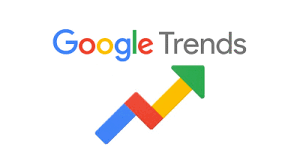

Movements in stock can reflect a lot of what happens in the world, but not all of it. To get a broader picture of what moves markets, we can also look at internet activity, particularly Google Trends. 

[Google Trends](https://trends.google.com/trends/?geo=US) is a platform by Google that analyzes the popularity of top search queries in Google Search across various regions and languages. 

## What Drives Price Movements?

Stocks prices move up and down for any number of reasons, particularly as unexpected news about them comes up. To learn more about how news interacts with stock prices, we can look plot [Google Trends] against stock prices themselves. 

Below is some code to help with that which builds on [`pytrends`](https://github.com/GeneralMills/pytrends), a package created and made freely available by the engineering team at [General Mills](https://www.generalmills.com/en/Brands). 



##### First, import (and install if necessary) `pytrends`

In [ ]:
try:
    from pytrends.request import TrendReq
except ModuleNotFoundError:
    !pip install pytrends
    from pytrends.request import TrendReq


In [ ]:
def plot_trends(terms=None, ticker=None):
    
    pytrends = TrendReq(hl='en-US', tz=360)
    if type(terms)==str:
        kw_list = [terms]
    else: 
        kw_list = terms
    pytrends.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='', gprop='')
    ts_df = pytrends.interest_over_time()
    ts_df.index = ts_df.index + pd.DateOffset(-2)
    
    stock_df = get_stock_prices(ticker)
    
    plot_df = pd.DataFrame(ts_df[terms]).join(price_df[ticker], how='inner')
    plot_df.plot(figsize=(15, 7))
    
    print(plot_df.corr())
    
plot_trends(['Mark Zuckerberg', 'Cambridge Analytica'], 'FB')